In [70]:
# Import statements and set up auth header
import requests
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from config import foursquare_key
auth_header = {"Authorization": foursquare_key}

In [53]:
# Test FourSquare API: Request autocomplete for search query and grab first result
query = "Ontario Tech University"
request = requests.get("https://api.foursquare.com/v3/autocomplete", params={'query': query}, headers=auth_header)
result = request.json()
# Output result to jupyter
result

{'results': [{'type': 'address',
   'text': {'primary': 'A-174 University Ave',
    'secondary': 'Kingston, ON, K7L 3P4',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a2b8b',
   'address': {'address_id': 'CA-435041340000000a2b8b'}},
  {'type': 'address',
   'text': {'primary': 'A-300 University Ave',
    'secondary': 'Kingston, ON, K7L 3R2',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a364e',
   'address': {'address_id': 'CA-435041340000000a364e'}},
  {'type': 'address',
   'text': {'primary': 'A-201 University Ave',
    'secondary': 'Kingston, ON, K7L 3P7',
    'highlight': [{'start': 0, 'length': 1}, {'start': 6, 'length': 10}]},
   'link': '/v3/address/CA-435041340000000a1a17',
   'address': {'address_id': 'CA-435041340000000a1a17'}},
  {'type': 'address',
   'text': {'primary': 'A-260 University Ave',
    'secondary': 'Kingston, ON, K7L 3P

In [54]:
# Return place for first result
place_link = result['results'][0]['link']
request_next = requests.get("https://api.foursquare.com" + place_link, headers=auth_header)
result_next = request_next.json()
# Output place address
result_next['location']['formatted_address']

KeyError: 'formatted_address'

In [ ]:
#Draw initial folium map using Toronto Police GeoJSON
m = folium.Map(location = [43.6532, - 79.3832], zoom_start=10)

toronto_neighbourhood_edge = f"data/TorontoNeighbourhoodCrimeRatesBoundaryFile.geojson"

folium.GeoJson(toronto_neighbourhood_edge, name="torontoEdge").add_to(m)

m

,Neighbourhood,Hood_ID,"Population, 2016",Assault_2016,Assault_Rate_2016,AutoTheft_2016,AutoTheft_Rate_2016,BreakandEnter_2016,BreakAndEnter_Rate_2016,Homicide_2016,...,Robbery_2016,Robbery_Rate_2016,TheftOver_2016,TheftOver_Rate_2016,Unemployed,Unemployment rate,Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data,Public transit,PublicTransit_Rate,Total income: Average amount ($)
0,West Humber-Clairville,1,33312,307,921.6,321,963.6,131,393.3,4,...,100,300.2,41,123.1,1705,9.6,15575,4380,28.12,31771
1,Mount Olive-Silverstone-Jamestown,2,32954,270,819.3,43,130.5,34,103.2,1,...,102,309.5,4,12.1,1785,12.1,12600,4110,32.62,26548
2,Thistletown-Beaumond Heights,3,10360,39,376.4,13,125.5,23,222.0,0,...,16,154.4,1,9.7,525,10.4,4345,1030,23.71,32815
3,Rexdale-Kipling,4,10529,77,731.3,22,208.9,16,152.0,0,...,17,161.5,0,0.0,600,10.9,4730,1345,28.44,34418
4,Elms-Old Rexdale,5,9456,61,645.1,16,169.2,10,105.8,0,...,18,190.4,0,0.0,465,10.0,4045,1330,32.88,32012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,27392,423,1544.2,15,54.8,72,262.9,0,...,77,281.1,8,29.2,1515,11.6,11050,3990,36.11,33323
136,Woburn,137,53485,365,682.4,31,58.0,80,149.6,1,...,67,125.3,14,26.2,2665,10.6,21595,7635,35.36,30878
137,Eglinton East,138,22776,201,882.5,22,96.6,65,285.4,0,...,40,175.6,6,26.3,1155,10.8,9265,4595,49.60,30033
138,Scarborough Village,139,16724,192,1148.1,9,53.8,34,203.3,6,...,22,131.5,2,12.0,980,13.0,6250,2570,41.12,32913


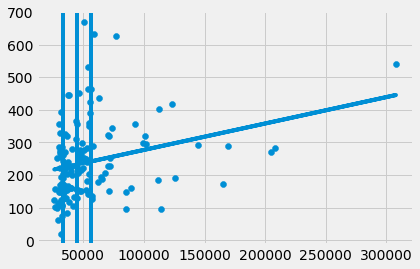

In [156]:
#Read csv into pandas dataframe
df = pd.read_csv("data/combinedDataset.csv")

#df = df[(np.abs(stats.zscore(df['Total income: Average amount ($)']))<3)]
#example to remove outliers depending on zscore

#use column headers as keys for x and y
x = df['Total income: Average amount ($)']
y = df['BreakAndEnter_Rate_2016']
#Create line of best fit from x vs. y
a, b = np.polyfit(x, y, 1)

#Draw scatter plot and plot line of best fit (just for our own visualization atm)
plt.scatter(x, y)
plt.plot(x, a*x+b)

#Drawing quartiles onto the plot
plt.axvline(np.quantile(x, 0.25))
plt.axvline(np.quantile(x, 0.5))
plt.axvline(np.quantile(x, 0.75))

df

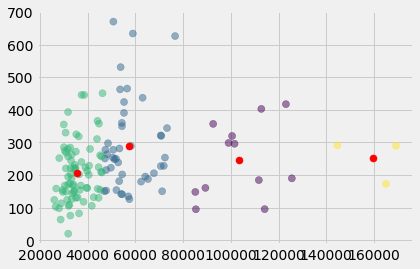

In [155]:
#testing clustering
#https://datatofish.com/k-means-clustering-python/ site i followed for clustering logic
k_df = pd.concat([df['Total income: Average amount ($)'],df['BreakAndEnter_Rate_2016']], axis=1, keys=['x', 'y'])

kmeans = KMeans(n_clusters=4).fit(k_df)
centroids = kmeans.cluster_centers_

plt.scatter(k_df['x'], k_df['y'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1,], c='red', s=50)
plt.show()
